# Part 4 (R)

# Statistical Analysis

This code provides the statistical analysis of the research paper: The Impact of Temperature and Precipitation on Annual Crop Yield in North America.


Paper and analysis by: 

Maxim Mahnkopf, Dominic Schierbaum and Nick van Nuland

Load R Library

In [23]:
library(ncdf4)
library(rasterVis)
library(raster) 
library(ggplot2)
library(rgdal)
library(sf)
library(pracma)
library(dplyr)
library(terra)
library(Metrics)

Set Path

In [24]:
# setwd("your/path")

# Data Preprocessing

Load Data

In [25]:
datacube <- nc_open("data/datacube_final.nc")

In [26]:
names(datacube[['var']])


[1] "temperature"   "precipitation" "lat"           "lon"          
[5] "maize"         "soybean"       "wheat"

In [27]:
# load variables
maize                     <-   raster::stack(raster::stack(datacube[1],varname="maize"))
soybean                   <-   raster::stack(raster::stack(datacube[1],varname="soybean"))
spring_wheat              <-   raster::stack(raster::stack(datacube[1],varname="wheat"))
precipitation             <-   raster::stack(raster::stack(datacube[1],varname="precipitation"))
temperature               <-   raster::stack(raster::stack(datacube[1],varname="temperature"))

Change Year Names

In [28]:
# creating a year vector
year_vector <- as.character(1982:2016)

# exchange
names(temperature@layers)[1:35] <- year_vector
names(precipitation@layers)[1:35] <- year_vector
names(maize@layers)[1:35] <- year_vector
names(soybean@layers)[1:35] <- year_vector
names(spring_wheat@layers)[1:35] <- year_vector

In [29]:
datacube <- stack(maize, soybean, spring_wheat, precipitation, temperature)

Check for NAs in Datacube

In [30]:
nlayers(datacube)

[1] 175

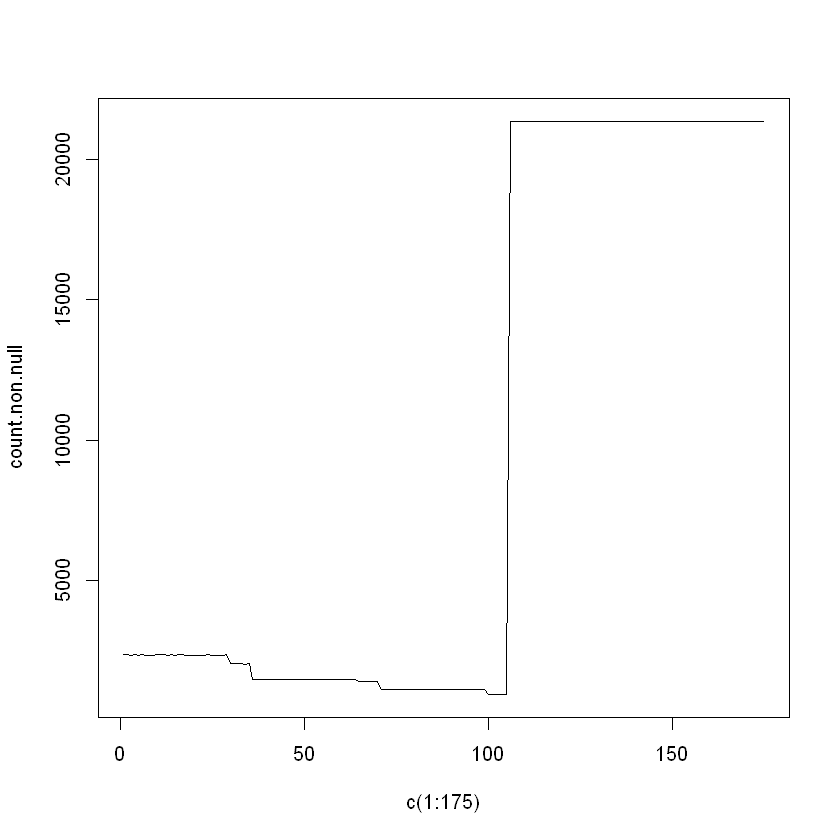

In [31]:
count.non.null <- list()
for (i in 1:175){                                          
  count.non.null[[i]] <- sum(!is.na(values(datacube[[i]]))) 
}
plot(c(1:175), count.non.null, type="l")

In [32]:
# while precipitation (106:140) and temperature (141:175) have no NA values, maize, soybean and spring_wheat have about 80% to 90% NA values. 
# this does make a lot of sense, since not more that 20% is agricultural area for each crop type
# also: the line for maize (1:35), soybean (36:70) and spring_wheat (71:105) is not straight --> this indicates that the years have inconsistent amounts of NA values

Clean Out All Rows with Inconcistent NAs

In [33]:
# for maize
maize.mask <- datacube[[35]]    # get the last year as mask
for (i in 1:35) {
  # Extract the data for the current year
  layer <- mask(datacube[[i]], maize.mask)
  # Add the cleaned data to the raster stack
   datacube[[i]] <- layer
}

# for soybean
soybean.mask <- datacube[[70]]
for (i in 36:70) {
  # Extract the data for the current year
  layer <- mask(datacube[[i]], soybean.mask)
  # Add the cleaned data to the raster stack
  datacube[[i]] <- layer
}

# for spring_wheat
wheat.mask <- datacube[[105]]
for (i in 71:105) {
  # Extract the data for the current year
  layer <- mask(datacube[[i]], wheat.mask)
  # Add the cleaned data to the raster stack
  datacube[[i]] <- layer
}


Detrend Crop Yield Data

In [34]:
# detrending with this detrend function from the pracma package:
fun_detr <- function(x) {detrend(x, tt='linear', bp=c())}

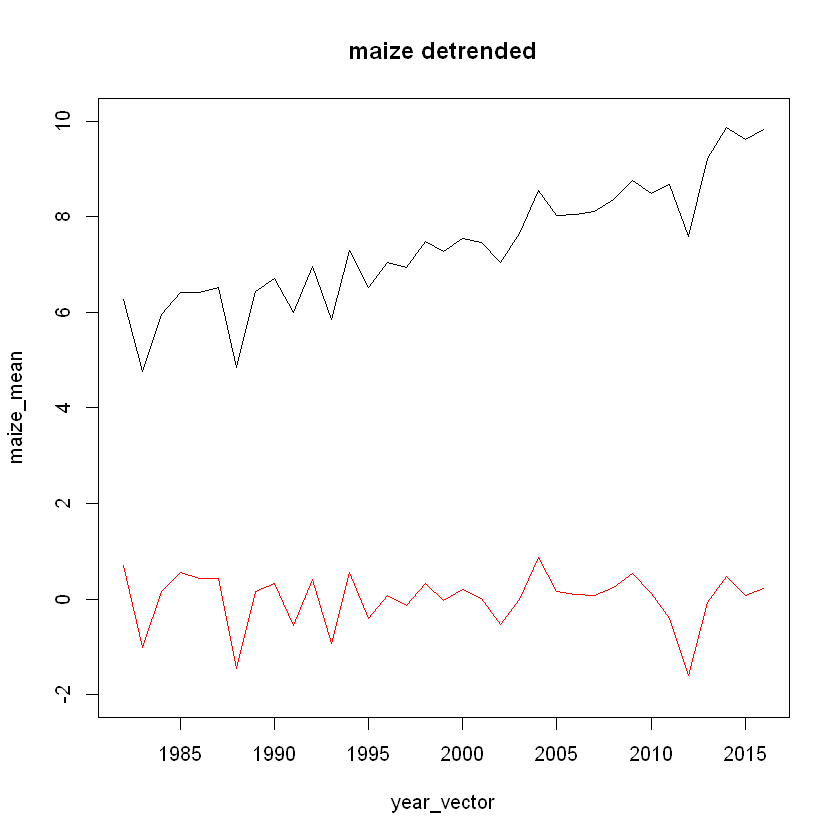

In [35]:
#maize
x1 <- calc(datacube[[1:35]], fun_detr)
maize_detrend <- stack()
for (i in 1:nlayers(x1)) {
  layer <- x1[[i]]
  datacube[[i]] <- layer  
}
#plot detre nding
maize_detrend_mean <- cellStats(datacube[[1:35]], mean)
maize_mean <- cellStats(maize, mean)
plot(year_vector, maize_mean , type="l", main="maize detrended",ylim = c(-2, 10))
lines(year_vector,maize_detrend_mean , type="l", col="red")

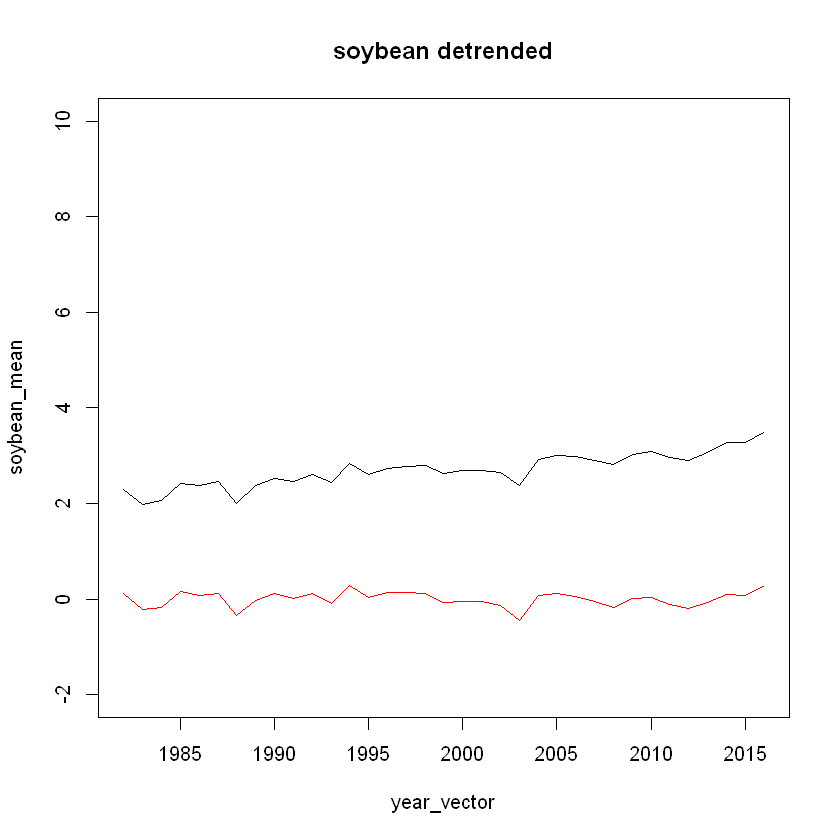

In [36]:
#soybean
x2 <- calc(datacube[[36:70]], fun_detr)
soybean_detrend <- stack()
for (i in 1:nlayers(x2)) {
  layer <- x2[[i]]
  datacube[[i+35]] <- layer  
}

#plot detrending
soybean_detrend_mean <- cellStats(datacube[[36:70]], mean)
soybean_mean <- cellStats(soybean, mean)
plot(year_vector, soybean_mean , type="l", main="soybean detrended",ylim = c(-2, 10))
lines(year_vector,soybean_detrend_mean , type="l", col="red")

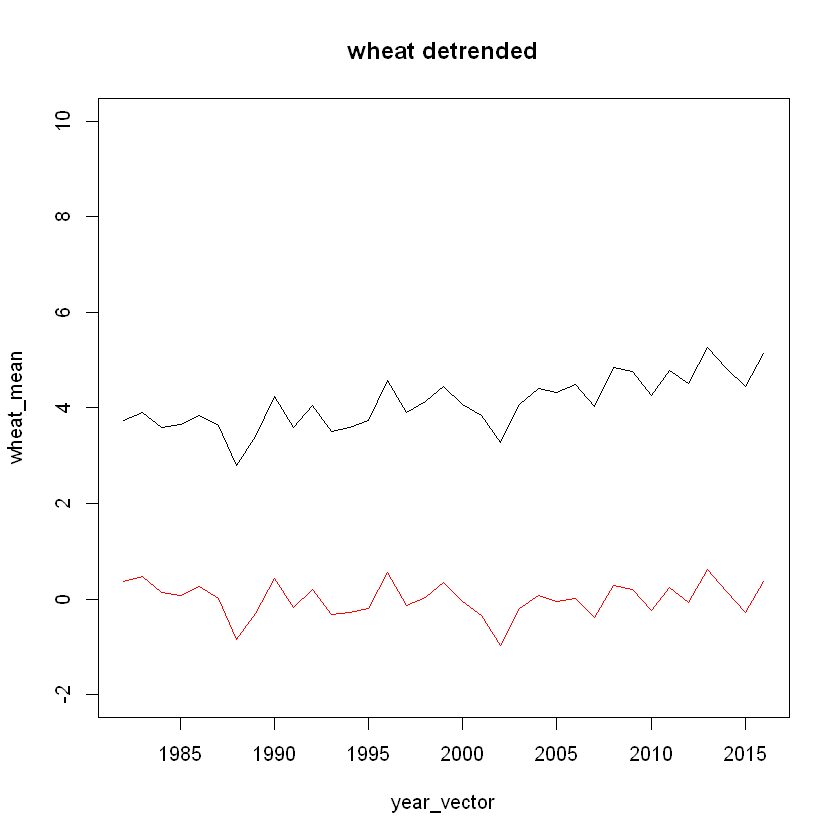

In [37]:
#wheat
x3 <- calc(datacube[[71:105]], fun_detr)
wheat_detrend <- stack()
for (i in 1:nlayers(x3)) {
  layer <- x3[[i]]
  datacube[[i+70]] <- layer  
}
#plot detrending
wheat_detrend_mean <- cellStats(datacube[[71:105]], mean)
wheat_mean <- cellStats(spring_wheat, mean)
plot(year_vector, wheat_mean , type="l", main="wheat detrended",ylim = c(-2, 10))
lines(year_vector,wheat_detrend_mean , type="l", col="red")

# Prediction Model (Linear Rregression): Temperature

Create Temperature Data Frame

In [38]:
# Create an empty data frame to store the values
x_df_temp <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object at index i
  x_values <- raster::values(temperature[[i]])
  
  # Create a new row in the data frame and assign the values to it
  x_df_temp <- rbind(x_df_temp, x_values)
}

# change col names
colnames(x_df_temp) <- c(1:21344)
# change from K to C
x_df_temp <- x_df_temp - 273

Create Crop Yield Data Frame

In [39]:
#--------------------------------------------------------------------###maize###
# Create an empty data frame to store the values
y_df_maize <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object 
  y_values <- raster::values(datacube[[i]])
  
  # Create a new row in the data frame and assign the values to it
  y_df_maize <- rbind(y_df_maize, y_values)
}
# change col names
colnames(y_df_maize) <- c(1:21344) 

#------------------------------------------------------------------###soybean###
# Create an empty data frame to store the values
y_df_soybean <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object
  y_values <- raster::values(datacube[[i+35]])
  
  # Create a new row in the data frame and assign the values to it
  y_df_soybean <- rbind(y_df_soybean, y_values)
}
# change col names
colnames(y_df_soybean) <- c(1:21344) 

#--------------------------------------------------------------------###spring_wheat###
# Create an empty data frame to store the values
y_df_wheat <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object
  y_values <- raster::values(datacube[[i+70]])
  
  # Create a new row in the data frame and assign the values to it
  y_df_wheat <- rbind(y_df_wheat, y_values)
}
# change col names
colnames(y_df_wheat) <- c(1:21344) 

Round Data - (Binning: For Noise Reduction)

In [40]:
#rotate data
x_temp <- t(x_df_temp)
y_maize <- t(y_df_maize)
y_soybean <- t(y_df_soybean)
y_wheat <- t(y_df_wheat)

#round data
x_temp <- round(x_temp, digits = 0)
data_temp_maize <- data.frame(x = x_temp, y = y_maize)
data_temp_soybean <- data.frame(x = x_temp, y = y_soybean)
data_temp_wheat <- data.frame(x = x_temp, y = y_wheat)

#--------------------------------------------------------------------------maize
#Combine all rows from columns x.1 to x.35 into a single x column
data_all_x_maize <- data_temp_maize  %>%
  select(starts_with("x.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("x")

#Combine all rows from columns y.1 to y.35 into a single y column
data_all_y_maize <- data_temp_maize %>%
  select(starts_with("y.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("y")

#Combine x and y dataframes into data_all
temp_maize <- cbind(data_all_x_maize, data_all_y_maize)

#calculate mean data frame
mean_temp_maize <- temp_maize %>%
  group_by(x) %>%
  summarise(y = mean(y,na.rm=T))
#------------------------------------------------------------------------soybean
#Combine all rows from columns x.1 to x.35 into a single x column
data_all_x_soybean <- data_temp_soybean  %>%
  select(starts_with("x.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("x")

#Combine all rows from columns y.1 to y.35 into a single y column
data_all_y_soybean <- data_temp_soybean %>%
  select(starts_with("y.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("y")

#Combine x and y dataframes into data_all
temp_soybean <- cbind(data_all_x_soybean, data_all_y_soybean)

#calculate mean data frame
mean_temp_soybean <- temp_soybean %>%
  group_by(x) %>%
  summarise(y = mean(y,na.rm=T))
#--------------------------------------------------------------------------wheat
#Combine all rows from columns x.1 to x.35 into a single x column
data_all_x_wheat <- data_temp_wheat  %>%
  select(starts_with("x.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("x")

#Combine all rows from columns y.1 to y.35 into a single y column
data_all_y_wheat <- data_temp_wheat %>%
  select(starts_with("y.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("y")

#Combine x and y dataframes into data_all
temp_wheat <- cbind(data_all_x_wheat, data_all_y_wheat)

#calculate mean data frame
mean_temp_wheat <- temp_wheat %>%
  group_by(x) %>%
  summarise(y = mean(y,na.rm=T))


Plot It

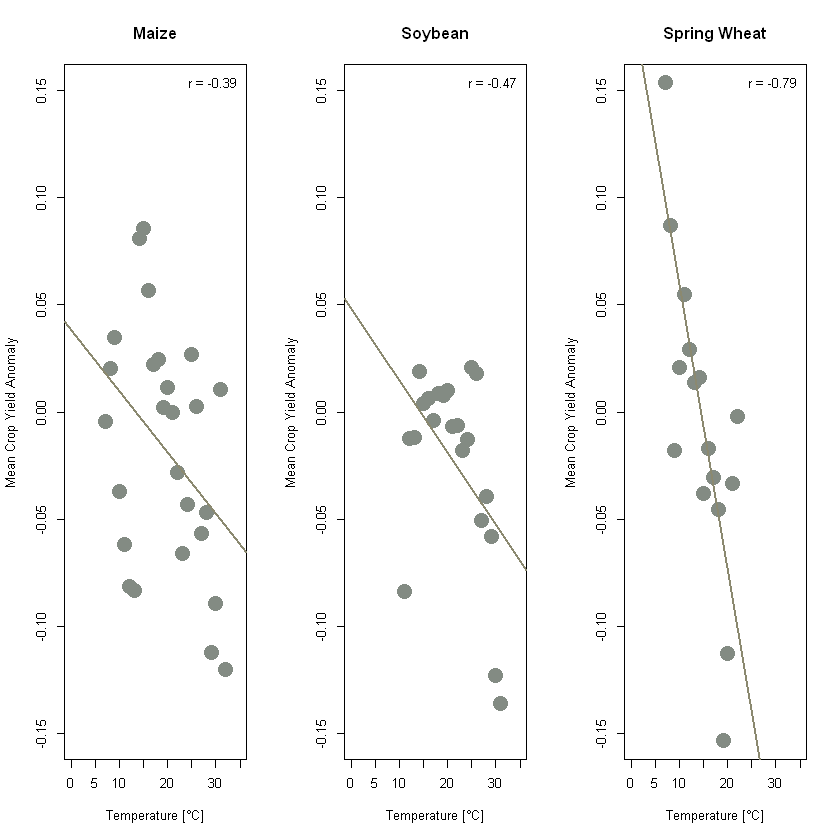

In [41]:
# Set up a 1x3 multi-panel layout
par(mfrow = c(1, 3))

# Plot for maize
plot(mean_temp_maize$x, mean_temp_maize$y, pch = 16, cex = 2.5, bg = "honeydew3", col = "honeydew4",
     xlab = "Temperature [°C]", ylab = "Mean Crop Yield Anomaly", main = "Maize", xlim = c(0, 35),ylim= c(-0.15, 0.15))
correlation <- cor(mean_temp_maize$x, mean_temp_maize$y, use = "complete.obs")
legend("topright", paste("r =", round(correlation, 2)), bty = "n")
regression_model <- lm(y ~ x, data = mean_temp_maize)
abline(regression_model, col = "lemonchiffon4",lwd=2)

# Plot for soybean
plot(mean_temp_soybean$x, mean_temp_soybean$y, pch = 16, cex = 2.5, bg = "honeydew3", col = "honeydew4",
     xlab = "Temperature [°C]", ylab = "Mean Crop Yield Anomaly", main = "Soybean", xlim = c(0, 35),ylim= c(-0.15, 0.15))
correlation <- cor(mean_temp_soybean$x, mean_temp_soybean$y, use = "complete.obs")
legend("topright", paste("r =", round(correlation, 2)), bty = "n")
regression_model <- lm(y ~ x, data = mean_temp_soybean)
abline(regression_model, col = "lemonchiffon4",lwd=2)

# Plot for wheat
plot(mean_temp_wheat$x, mean_temp_wheat$y, pch = 16, cex = 2.5, bg = "honeydew3", col = "honeydew4",
     xlab = "Temperature [°C]", ylab = "Mean Crop Yield Anomaly", main = "Spring Wheat", xlim = c(0, 35),ylim= c(-0.15, 0.15))
correlation <- cor(mean_temp_wheat$x, mean_temp_wheat$y, use = "complete.obs")
legend("topright", paste("r =", round(correlation, 2)), bty = "n")
regression_model <- lm(y ~ x, data = mean_temp_wheat)
abline(regression_model, col = "lemonchiffon4",lwd=2)

# Reset the layout to a single panel
par(mfrow = c(1, 1))

# Prediction Model (Linear Rregression): Precipitation

Create Precipitation Data Frame


In [42]:
# Create an empty data frame to store the values
x_df_prec <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object at index i
  x_values <- raster::values(datacube[[i+105]])
  
  # Create a new row in the data frame and assign the values to it
  x_df_prec <- rbind(x_df_prec, x_values)
}
# change col names
colnames(x_df_prec) <- c(1:21344)

Create Crop Yield Data Frame

In [43]:
#--------------------------------------------------------------------###maize###
# Create an empty data frame to store the values
y_df_maize <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object
  y_values <- raster::values(datacube[[i]])
  
  # Create a new row in the data frame and assign the values to it
  y_df_maize <- rbind(y_df_maize, y_values)
}
# change col names
colnames(y_df_maize) <- c(1:21344) 

#------------------------------------------------------------------###soybean###
# Create an empty data frame to store the values
y_df_soybean <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object
  y_values <- raster::values(datacube[[i+35]])
  
  # Create a new row in the data frame and assign the values to it
  y_df_soybean <- rbind(y_df_soybean, y_values)
}
# change col names
colnames(y_df_soybean) <- c(1:21344) 

#--------------------------------------------------------------------###wheat###
# Create an empty data frame to store the values
y_df_wheat <- data.frame()
# Loop through the indices from 1 to 35
for (i in 1:35) {
  # Extract values from the raster object
  y_values <- raster::values(datacube[[i+70]])
  
  # Create a new row in the data frame and assign the values to it
  y_df_wheat <- rbind(y_df_wheat, y_values)
}
# change col names
colnames(y_df_wheat) <- c(1:21344) 

Round Data (Binning: For Noise Reduction)

In [44]:
#rotate data
x_prec <- t(x_df_prec)
y_maize <- t(y_df_maize)
y_soybean <- t(y_df_soybean)
y_wheat <- t(y_df_wheat)

#round data
x_prec <- round(x_prec, digits = 0)
data_prec_maize <- data.frame(x = x_prec, y = y_maize)
data_prec_soybean <- data.frame(x = x_prec, y = y_soybean)
data_prec_wheat <- data.frame(x = x_prec, y = y_wheat)

#--------------------------------------------------------------------------maize
#Combine all rows from columns x.1 to x.35 into a single x column
data_all_x_maize <- data_prec_maize  %>%
  select(starts_with("x.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("x")

#Combine all rows from columns y.1 to y.35 into a single y column
data_all_y_maize <- data_prec_maize %>%
  select(starts_with("y.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("y")

#Combine x and y dataframes into data_all
prec_maize <- cbind(data_all_x_maize, data_all_y_maize)

#calculate mean data frame
mean_prec_maize <- prec_maize %>%
  group_by(x) %>%
  summarise(y = mean(y,na.rm=T))
#------------------------------------------------------------------------soybean
#Combine all rows from columns x.1 to x.35 into a single x column
data_all_x_soybean <- data_prec_soybean  %>%
  select(starts_with("x.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("x")

#Combine all rows from columns y.1 to y.35 into a single y column
data_all_y_soybean <- data_prec_soybean %>%
  select(starts_with("y.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("y")

#Combine x and y dataframes into data_all
prec_soybean <- cbind(data_all_x_soybean, data_all_y_soybean)

#calculate mean data frame
mean_prec_soybean <- prec_soybean %>%
  group_by(x) %>%
  summarise(y = mean(y,na.rm=T))
#--------------------------------------------------------------------------wheat
#Combine all rows from columns x.1 to x.35 into a single x column
data_all_x_wheat <- data_prec_wheat  %>%
  select(starts_with("x.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("x")

#Combine all rows from columns y.1 to y.35 into a single y column
data_all_y_wheat <- data_prec_wheat %>%
  select(starts_with("y.")) %>%
  unlist() %>%
  as.data.frame() %>%
  setNames("y")

#Combine x and y dataframes into data_all
prec_wheat <- cbind(data_all_x_wheat, data_all_y_wheat)

#calculate mean data frame
mean_prec_wheat <- prec_wheat %>%
  group_by(x) %>%
  summarise(y = mean(y,na.rm=T))

Plot It

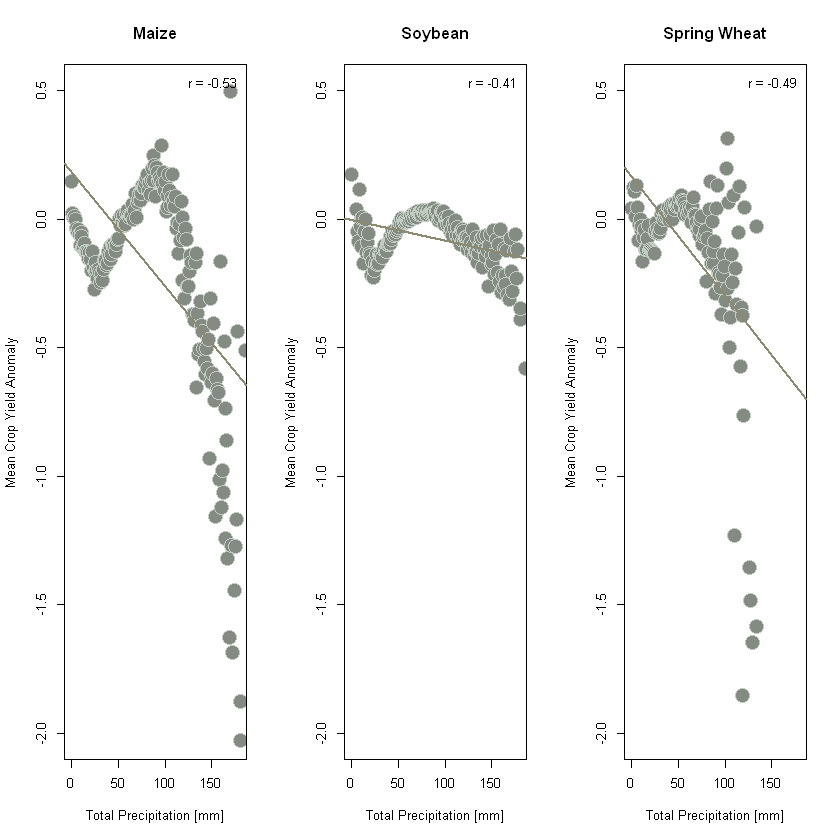

In [45]:
# Set up a 1x3 multi-panel layout
par(mfrow = c(1, 3))

# Plot for maize
plot(mean_prec_maize$x, mean_prec_maize$y, pch = 21, cex = 2.5,bg = "honeydew4", col = "honeydew3",
     xlab = "Total Precipitation [mm]", ylab = "Mean Crop Yield Anomaly", main = "Maize", xlim = c(0, 180),ylim=c(-2,0.5))
correlation <- cor(mean_prec_maize$x, mean_prec_maize$y, use = "complete.obs")
legend("topright", paste("r =", round(correlation, 2)), bty = "n")
regression_model <- lm(y ~ x, data = mean_prec_maize)
abline(regression_model, col = "lemonchiffon4",lwd=2)

# Plot for soybean
plot(mean_prec_soybean$x, mean_prec_soybean$y, pch = 21, cex = 2.5,bg = "honeydew4", col = "honeydew3",
     xlab = "Total Precipitation [mm]", ylab = "Mean Crop Yield Anomaly", main = "Soybean", xlim = c(0, 180),ylim=c(-2,0.5))
correlation <- cor(mean_prec_soybean$x, mean_prec_soybean$y, use = "complete.obs")
legend("topright", paste("r =", round(correlation, 2)), bty = "n")
regression_model <- lm(y ~ x, data = mean_prec_soybean)
abline(regression_model, col = "lemonchiffon4",lwd=2)

# Plot for wheat
plot(mean_prec_wheat$x, mean_prec_wheat$y, pch = 21, cex = 2.5,bg = "honeydew4", col = "honeydew3",
     xlab = "Total Precipitation [mm]", ylab = "Mean Crop Yield Anomaly", main = "Spring Wheat", xlim = c(0, 180),ylim=c(-2,0.5))
correlation <- cor(mean_prec_wheat$x, mean_prec_wheat$y, use = "complete.obs")
legend("topright", paste("r =", round(correlation, 2)), bty = "n")
regression_model <- lm(y ~ x, data = mean_prec_wheat)
abline(regression_model, col = "lemonchiffon4",lwd=2)

# Reset the layout to a single panel
par(mfrow = c(1, 1))


# Multiple Linear Regression (Spatial Patterns)

### 1. MAIZE

In [46]:
# Precipitation Coefficient
fun=function(x) { if (is.na(x[1])){ NA } else { m = lm(scale(x[1:35]) ~ scale(x[106:140]) + scale(x[141:175]));summary(m)$coefficients[2]}} #climate variables: Precipitation
maize.precipitation.coeff <- calc(datacube, fun)

# Air Temperature Mean
fun=function(x) { if (is.na(x[1])){ NA } else { m = lm(scale(x[1:35]) ~ scale(x[106:140]) + scale(x[141:175]));summary(m)$coefficients[3]}} #climate variables: Precipitation
maize.air.temperature.coeff <- calc(datacube, fun)

# rsquared
r2=function(x) { if (is.na(x[1])){ NA } else {m <- lm((x[1:35]) ~  (x[106:140]) + (x[141:175]));summary(m)$adj.r.squared}}
maize.rsquared <- calc(datacube, r2)

# student's t-test 
ttest=function(x) { if (is.na(x[1])){ NA } else {m <- lm(scale(x[1:35]) ~ scale(x[106:140]) + scale(x[141:175])); pf(summary(m)$fstatistic["value"],summary(m)$fstatistic["numdf"],summary(m)$fstatistic["dendf"],lower.tail=F)}} #confidence intervall of 95%
maize.pvalue <- calc(datacube, ttest)

# alpha level 0.05
maize.sign <- maize.pvalue
maize.sign[maize.sign > 0.05] <- NA

# root mean error 
rmse_=function(x) { if (is.na(x[1])){ NA } else {m <- lm(((x[1:35])) ~ + (x[106:140]) + (x[141:175])); sqrt(mean(m$residuals^2))}} 
maize.rmse <- calc(datacube, rmse_)


Plot Maize

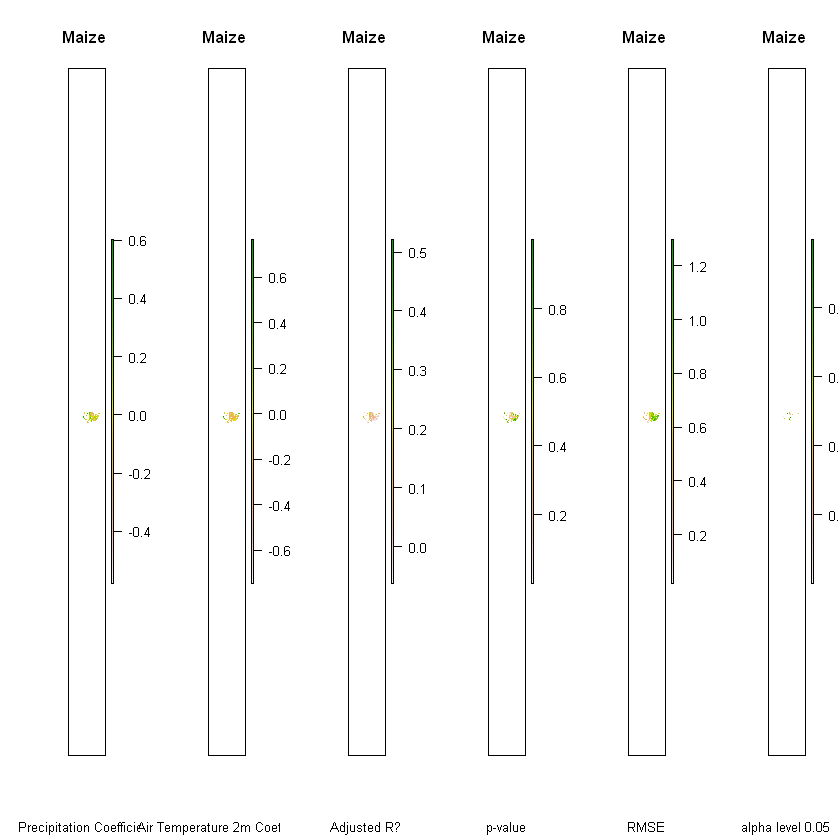

In [47]:
par(mfrow = c(1, 6))
main_title <- "Maize "

# Plot each coefficient
plot(maize.precipitation.coeff, main= main_title, sub = "Precipitation Coefficient", axes= FALSE)
plot(maize.air.temperature.coeff, main= main_title, sub = "Air Temperature 2m Coefficient",axes= FALSE)
plot(maize.rsquared,     main= main_title, sub = "Adjusted R?",axes= FALSE)
plot(maize.pvalue,       main= main_title, sub = "p-value",axes= FALSE)
plot(maize.rmse,         main= main_title, sub = "RMSE",axes= FALSE)
plot(maize.sign,         main= main_title, sub = "alpha level 0.05",axes= FALSE)

### 2 SOYBEAN

In [48]:
# Precipitation Coefficient
fun=function(x) { if (is.na(x[36])){ NA } else { m <-lm(scale(x[36:70]) ~ scale(x[106:140]) + scale(x[141:175]));summary(m)$coefficients[2]}} #climate variables: Precipitation
soybean.precipitation.coeff <- calc(datacube, fun)

# Air Temperature Mean
fun=function(x) { if (is.na(x[36])){ NA } else { m <- lm(scale(x[36:70]) ~ scale(x[106:140]) + scale(x[141:175]));summary(m)$coefficients[3]}} #climate variables: Precipitation
soybean.air.temperature.coeff <- calc(datacube, fun)

# rsquared
r2=function(x) { if (is.na(x[36])){ NA } else {m <- lm((x[36:70]) ~  (x[106:140]) + (x[141:175]));summary(m)$adj.r.squared}}
soybean.rsquared <- calc(datacube, r2)

# student's t-test 
ttest=function(x) { if (is.na(x[36])){ NA } else {m <- lm(scale(x[36:70]) ~ scale(x[106:140]) + scale(x[141:175])); pf(summary(m)$fstatistic["value"],summary(m)$fstatistic["numdf"],summary(m)$fstatistic["dendf"],lower.tail=F)}} #confidence intervall of 95%
soybean.pvalue <- calc(datacube, ttest)

# alpha level 0.05
soybean.sign <- soybean.pvalue
soybean.sign[soybean.sign > 0.05] <- NA

# root mean error 
rmse_=function(x) { if (is.na(x[36])){ NA } else {m <- lm(((x[36:70])) ~ + (x[106:140]) + (x[141:175])); sqrt(mean(m$residuals^2))}} 
soybean.rmse <- calc(datacube, rmse_)

Plot Soybean

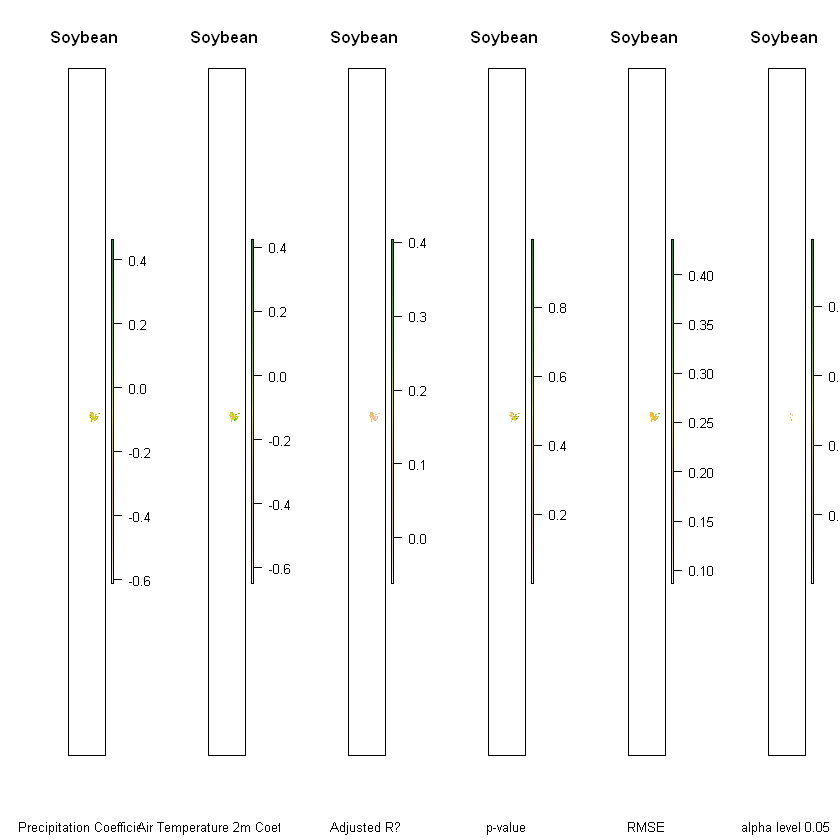

In [49]:
par(mfrow = c(1, 6))
main_title <- "Soybean "

# Plot each coefficient
plot(soybean.precipitation.coeff, main= main_title, sub = "Precipitation Coefficient", axes= FALSE)
plot(soybean.air.temperature.coeff, main= main_title, sub = "Air Temperature 2m Coefficient",axes= FALSE)
plot(soybean.rsquared,     main= main_title, sub = "Adjusted R?",axes= FALSE)
plot(soybean.pvalue,       main= main_title, sub = "p-value",axes= FALSE)
plot(soybean.rmse,         main= main_title, sub = "RMSE",axes= FALSE)
plot(soybean.sign,         main= main_title, sub = "alpha level 0.05",axes= FALSE)

### 3 SPRING WHEAT

In [50]:
# Precipitation Coefficient
fun=function(x) { if (is.na(x[71])){ NA } else {m <- lm(scale(x[71:105]) ~ scale(x[106:140]) + scale(x[141:175]));summary(m)$coefficients[2]}} #climate variables: Precipitation
wheat.precipitation.coeff <- calc(datacube, fun)

# Air Temperature Mean
fun=function(x) { if (is.na(x[71])){ NA } else {m <- lm(scale(x[71:105]) ~ scale(x[106:140]) + scale(x[141:175]));summary(m)$coefficients[3]}} #climate variables: Precipitation
wheat.air.temperature.coeff <- calc(datacube, fun)

# rsquared
r2=function(x) { if (is.na(x[71])){ NA } else {m <- lm((x[71:105]) ~  (x[106:140]) + (x[141:175]));summary(m)$adj.r.squared}}
wheat.rsquared <- calc(datacube, r2)

# student's t-test 
ttest=function(x) { if (is.na(x[71])){ NA } else {m <- lm(scale(x[71:105]) ~ scale(x[106:140]) + scale(x[141:175])); pf(summary(m)$fstatistic["value"],summary(m)$fstatistic["numdf"],summary(m)$fstatistic["dendf"],lower.tail=F)}} #confidence intervall of 95%
wheat.pvalue <- calc(datacube, ttest)

# alpha level 0.05
wheat.sign <- wheat.pvalue
wheat.sign[wheat.sign > 0.05] <- NA

# root mean error 
rmse_=function(x) { if (is.na(x[71])){ NA } else {m <- lm(((x[71:105])) ~ + (x[106:140]) + (x[141:175])); sqrt(mean(m$residuals^2))}} 
wheat.rmse <- calc(datacube, rmse_)

Plot Spring Wheat

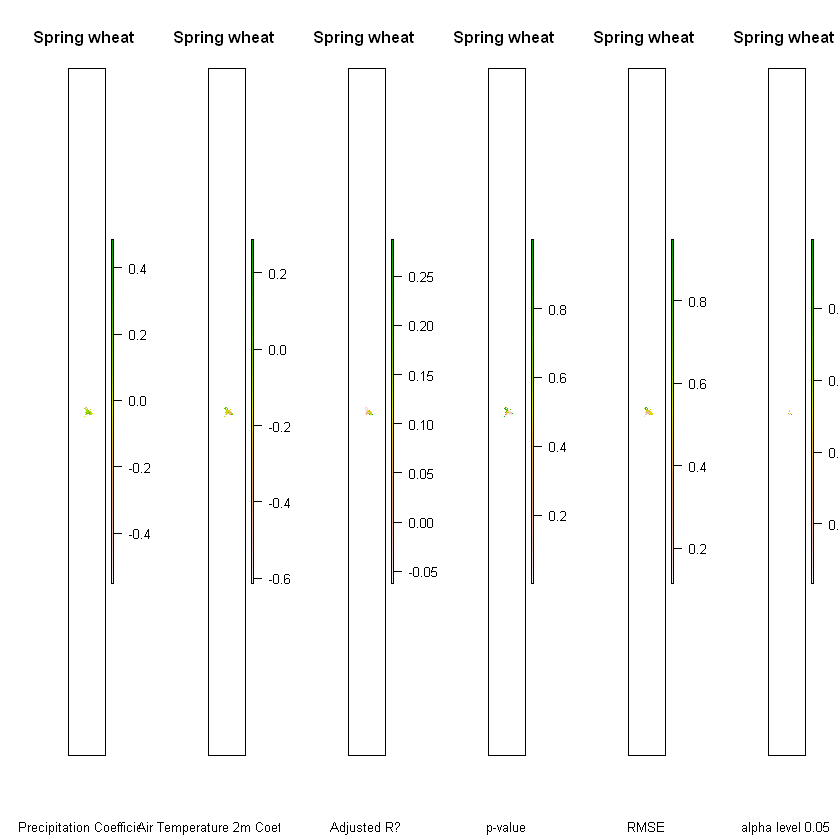

In [51]:
par(mfrow = c(1, 6))
main_title <- "Spring wheat "

# Plot each coefficient
plot(wheat.precipitation.coeff, main= main_title, sub = "Precipitation Coefficient", axes= FALSE)
plot(wheat.air.temperature.coeff, main= main_title, sub = "Air Temperature 2m Coefficient",axes= FALSE)
plot(wheat.rsquared,     main= main_title, sub = "Adjusted R?",axes= FALSE)
plot(wheat.pvalue,       main= main_title, sub = "p-value",axes= FALSE)
plot(wheat.rmse,         main= main_title, sub = "RMSE",axes= FALSE)
plot(wheat.sign,         main= main_title, sub = "alpha level 0.05",axes= FALSE)

Plots were edited in QGIS